# Лабораторная работа №5

## Ансамбли моделей машинного обучения.

### Задание:

1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите следующие ансамблевые модели:
   * одну из моделей группы бэггинга (бэггинг или случайный лес или сверхслучайные деревья);
   * одну из моделей группы бустинга;
   * одну из моделей группы стекинга.
5. (+1 балл на экзамене) Дополнительно к указанным моделям обучите еще две модели:
   * Модель многослойного персептрона. По желанию, вместо библиотеки scikit-learn возможно использование библиотек TensorFlow, PyTorch или других аналогичных библиотек.
   * Модель МГУА с использованием библиотеки - https://github.com/kvoyager/GmdhPy (или аналогичных библиотек). Найдите такие параметры запуска модели, при которых она будет по крайней мере не хуже, чем одна из предыдущих ансамблевых моделей.
6. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib_inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline 
sns.set(style="ticks")
from io import StringIO
from IPython.display import Image
import graphviz
import pydotplus
from sklearn.metrics import mean_absolute_error

In [104]:
data = pd.read_csv('world_population.csv', sep=",")

In [105]:
# Размер набора данных
data.shape

(234, 17)

In [106]:
# Типы колонок
data.dtypes

Rank                             int64
CCA3                            object
Country/Territory               object
Capital                         object
Continent                       object
2022 Population                  int64
2020 Population                  int64
2015 Population                  int64
2010 Population                  int64
2000 Population                  int64
1990 Population                  int64
1980 Population                  int64
1970 Population                  int64
Area (km²)                       int64
Density (per km²)              float64
Growth Rate                    float64
World Population Percentage    float64
dtype: object

In [107]:
# Проверяем есть ли пропущенные значенияк
data.isnull().sum()

Rank                           0
CCA3                           0
Country/Territory              0
Capital                        0
Continent                      0
2022 Population                0
2020 Population                0
2015 Population                0
2010 Population                0
2000 Population                0
1990 Population                0
1980 Population                0
1970 Population                0
Area (km²)                     0
Density (per km²)              0
Growth Rate                    0
World Population Percentage    0
dtype: int64

In [108]:
# Первые 5 строк датасета
data.head()

,Rank,CCA3,Country/Territory,Capital,Continent,2022 Population,2020 Population,2015 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Area (km²),Density (per km²),Growth Rate,World Population Percentage
0,36,AFG,Afghanistan,Kabul,Asia,41128771,38972230,33753499,28189672,19542982,10694796,12486631,10752971,652230,63.0587,1.0257,0.52
1,138,ALB,Albania,Tirana,Europe,2842321,2866849,2882481,2913399,3182021,3295066,2941651,2324731,28748,98.8702,0.9957,0.04
2,34,DZA,Algeria,Algiers,Africa,44903225,43451666,39543154,35856344,30774621,25518074,18739378,13795915,2381741,18.8531,1.0164,0.56
3,213,ASM,American Samoa,Pago Pago,Oceania,44273,46189,51368,54849,58230,47818,32886,27075,199,222.4774,0.9831,0.00
4,203,AND,Andorra,Andorra la Vella,Europe,79824,77700,71746,71519,66097,53569,35611,19860,468,170.5641,1.0100,0.00


In [109]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 234


### Кодирование категориальных признаков
Преобразуем названия стран, городов, ... в числовые зеачения (label encoding)

In [110]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [111]:
le = LabelEncoder()
    # "Continent"
le.fit(data.Continent.drop_duplicates()) 
data.Continent = le.transform(data.Continent)
    # "	Country/Territory"
le.fit(data["Country/Territory"].drop_duplicates()) 
data["Country/Territory"] = le.transform(data["Country/Territory"])

C:\Users\sashu\AppData\Local\Temp\ipykernel_11344\1110763721.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(method='pearson'), ax=ax, annot=True, fmt='.3f')


<Axes: >

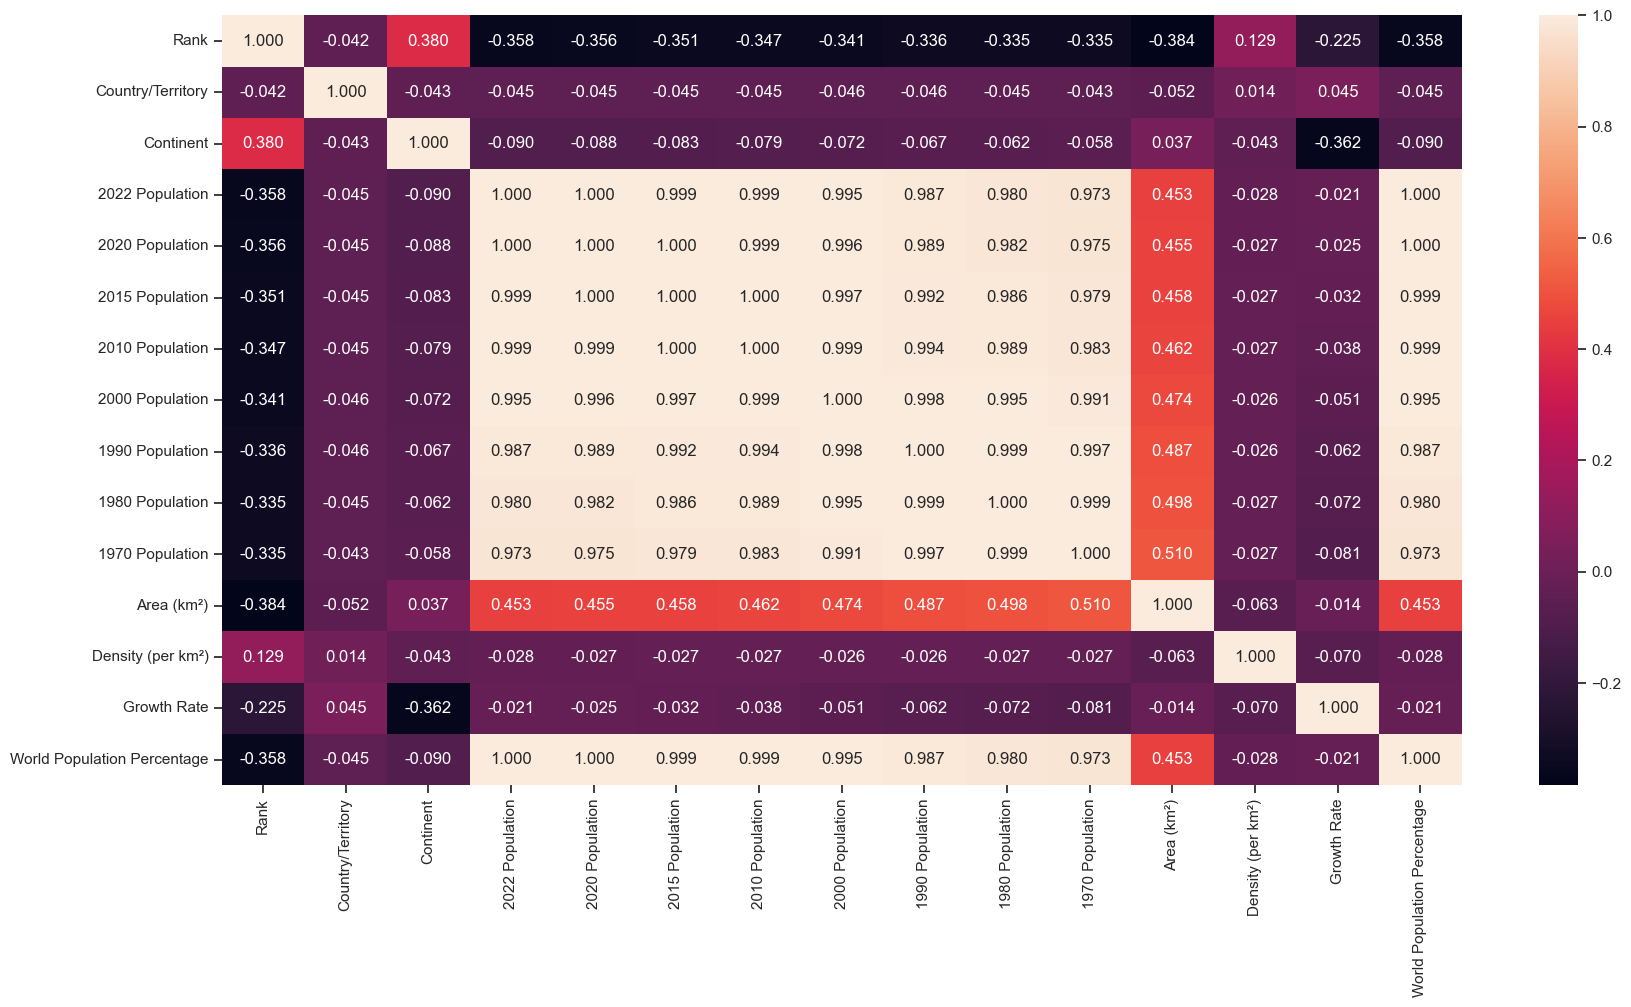

In [112]:
ig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(data.corr(method='pearson'), ax=ax, annot=True, fmt='.3f')

### Предсказание целевого признака
Предскажем значение целевого признака "2022 Population" по "2010 Population", "2000 Population" и "1990 Population", поскольку их значения кореляции ближе всего к 1

Разбиение выборки на обучающую и тестовую

In [113]:
X = data[["2010 Population", "2000 Population", "1990 Population"]]
Y = data["2022 Population"]
print('Входные данные:\n\n', X.head(), '\n\nВыходные данные:\n\n', Y.head())

Входные данные:

    2010 Population  2000 Population  1990 Population
0         28189672         19542982         10694796
1          2913399          3182021          3295066
2         35856344         30774621         25518074
3            54849            58230            47818
4            71519            66097            53569 

Выходные данные:

 0    41128771
1     2842321
2    44903225
3       44273
4       79824
Name: 2022 Population, dtype: int64


In [114]:
# Разделим выборку на обучающую и тестовую
X_train,  X_test,  Y_train,  Y_test = train_test_split(X,  Y, random_state = 2022, test_size = 0.1)

In [115]:
# Входные параметры обучающей выборки
X_train.head()

,2010 Population,2000 Population,1990 Population
213,73195345,64113547,54324142
111,2101530,2392530,2689391
135,2702520,2450979,2161433
202,22337563,16307654,12408996
232,13792086,9891136,7686401


In [116]:
# Входные параметры тестовой выборки
X_test.head()

,2010 Population,2000 Population,1990 Population
127,392181,432543,374271
73,3836831,4265172,5391636
182,29411929,21547390,16004763
22,63447,61371,57470
32,9126605,6307659,5483793


In [117]:
# Выходные параметры обучающей выборки
Y_train.head()

213    85341241
111     1850651
135     3398366
202    22125249
232    20017675
Name: 2022 Population, dtype: int64

In [118]:
# Выходные параметры тестовой выборки
Y_test.head()

127      367507
73      3744385
182    36408820
22        64184
32     12889576
Name: 2022 Population, dtype: int64

In [119]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score, precision_score

def test_model(model):
    print('precision: {}'.format(round(precision_score(Y_test, model.predict(X_test)), 2)))

## Обучение моделей
### Случайный лес

In [143]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [144]:
# Обучим регрессор на 3 деревьях
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

In [145]:
tree1 = RandomForestRegressor(n_estimators=5, oob_score=True, random_state=2022)
tree1.fit(X, Y)

C:\Users\sashu\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=5, oob_score=True, random_state=2022)

In [146]:
# Посмотрим важность признаков в каждом из деревьев
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(10,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

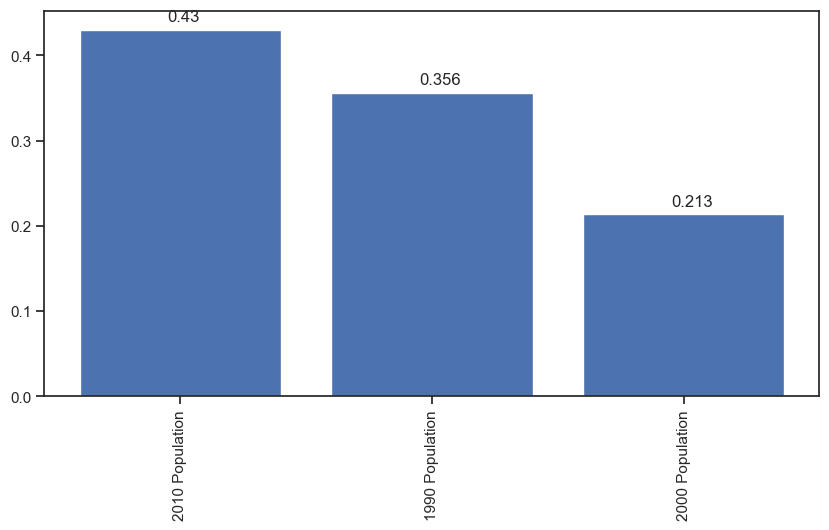

In [147]:
data_rf_reg = RandomForestRegressor(random_state=2022)
data_rf_reg.fit(X, Y)
_,_ = draw_feature_importances(data_rf_reg, X)

In [148]:
y_pred1 = tree1.predict(X_test)

In [149]:
print('Средняя абсолютная ошибка:',   mean_absolute_error(Y_test, y_pred1))

Средняя абсолютная ошибка: 570060.6749999999


### Бустинг

In [138]:
from sklearn.ensemble import AdaBoostRegressor

In [139]:
# Обучим регрессор на 3 деревьях
ab1 = AdaBoostRegressor(n_estimators=3, random_state=2022)
ab1.fit(X, Y)

AdaBoostRegressor(n_estimators=3, random_state=2022)

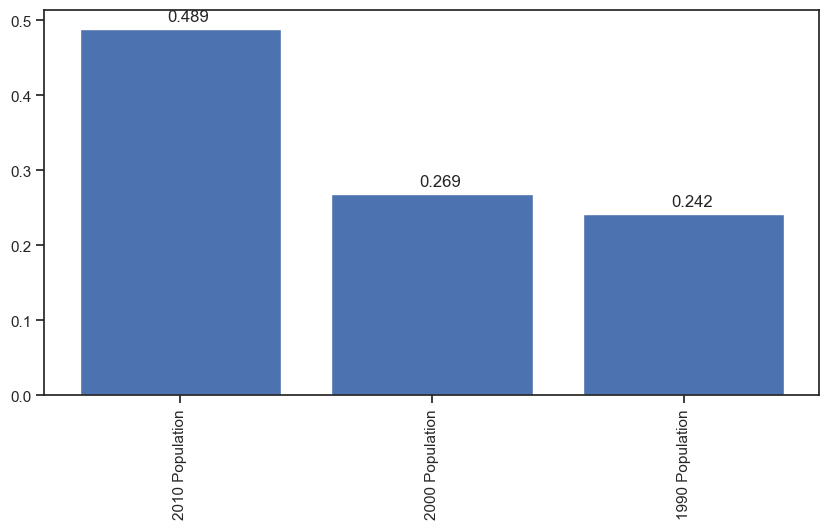

In [140]:
# Проверим важность признаков в модели
ab2 = AdaBoostRegressor(random_state=2022)
ab2.fit(X, Y)
_,_ = draw_feature_importances(ab2, X)

In [141]:
y_pred2 = ab1.predict(X_test)

In [142]:
print('Средняя абсолютная ошибка:',   mean_absolute_error(Y_test, y_pred2))

Средняя абсолютная ошибка: 4664851.085177342


### Стекинг

In [133]:
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

In [134]:
# Качество отдельных моделей
def val_mae(model):
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    result = mean_absolute_error(Y_test, y_pred)
    print(model)
    print('MAE={}'.format(result))

In [135]:
# Проверим точность на отдельных моделях
from sklearn.linear_model import LinearRegression

In [136]:
for model in [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=50)
]:
    val_mae(model)
    print('==========================')
    print()

LinearRegression()
MAE=1159304.8903917063

DecisionTreeRegressor()
MAE=1009820.7916666666

RandomForestRegressor(n_estimators=50)
MAE=797710.3891666668

